In [1]:
import pandas as pd
import numpy as np
import empyrical as ep
from datetime import datetime, timedelta

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
from __future__ import annotations
from pandas_market_calendars import get_calendar

In [4]:
#设计一个观察日的函数
def get_same_day_dates(start_date, n ,lock):
    dates = []
    begin_date=datetime.strptime(start_date, '%Y-%m-%d')
    for i in range(lock,n+1):
        print(i)
        current_date = begin_date
        time=i
        current_date += relativedelta(months=time)  # 将日期增加一个月
        dates.append(current_date.strftime('%Y-%m-%d'))  # 将日期对象转换为字符串格式并添加到列表中
    return dates

In [5]:
from pandas_market_calendars import get_calendar

# 获取上交所交易日历对象
sh_exchange_calendar = get_calendar('XSHG')

# 指定开始日期和结束日期
start_date = pd.to_datetime('2004-01-01')
mid_date1=pd.to_datetime('2022-09-09')
mid_date2=pd.to_datetime('2022-09-13')
end_date = pd.to_datetime('2026-12-31')

# 获取交易日日期列表
trading_days1 = sh_exchange_calendar.valid_days(start_date=start_date, end_date=mid_date1)
trading_days2 = sh_exchange_calendar.valid_days(start_date=mid_date2, end_date=end_date)

# 将交易日日期列表转换为字符串格式
trading_days_list = trading_days1.strftime('%Y-%m-%d').tolist()+trading_days2.strftime('%Y-%m-%d').tolist()
dates_to_remove = ['2022-10-06', '2022-10-07','2023-05-02','2023-05-03','2023-06-23']

for date in dates_to_remove:
    if date in trading_days_list:
        trading_days_list.remove(date)

In [6]:
#若为非交易日,则往后顺延到最近的交易日

def adjust_to_trading_days(dates, trading_days_list):
    adjusted_dates = []

    trading_days = pd.to_datetime(trading_days_list)

    for date in dates:
        dt = pd.to_datetime(date)

        if dt in trading_days:
            adjusted_dates.append(date)
        else:
            next_trading_day = trading_days[trading_days > dt].min()
            adjusted_dates.append(next_trading_day.strftime('%Y-%m-%d'))

    return adjusted_dates

In [7]:
#新撰写一个函数，作为后面计算降敲函数敲出价的辅助，date为单个日期，obs_date为日期列表，
#返回列表中早于单个日期列表的个数
def count_earlier_dates(date, obs_date):
    count = 0
    given_date = datetime.strptime(date, '%Y-%m-%d')
    
    for date_str in obs_date:
        obs = datetime.strptime(date_str, '%Y-%m-%d')
        if obs < given_date:
            count += 1
    
    return count

## 看涨价差结构

In [8]:
#形成最终的结果函数
#n代表产品的期限,r代表能达到的收益率上限，达到上限在下文中称为突破
#begin_date代表开始日期，end_date代表终止日期,interrupt_date代表截断日期，roll_length代表PB,PE分位数向前滚动的天数
def call_spread1(df_all,df_pbpe,n,r,begin_date,end_date,interrupt_date,roll_length):
    df_pbpe['PB分位数']=df_pbpe['PB'].rolling(roll_length).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
    df_pbpe['PE分位数']=df_pbpe['PE'].rolling(roll_length).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
    df=df_all
    df.columns=['date','标的指数收盘价']
    df.index=df['date']
    df['突破价格'] = (1+r)*df['标的指数收盘价']
    
    #新增一列记录是否发生敲出/发生突破
    df['是否突破']=0
    
    #新增一列记录敲出或者到期或者截断的时间
    df['突破或者到期时间']=0
    
    #新增一列记录产品敲出时指数点位
    df['突破或到期时指数点位']=0
    
    #新增一列填入产品收益率
    df['年化收益率']=0
    
    #新增一列计算当前指数点位的历史分位数（滚动周期与PBPE计算周期相同）
    df['指数点位历史分位数']=df['标的指数收盘价'].rolling(roll_length).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
    
    #新增一列判断产品是否存续
    df['产品当前是否存续']=0
    
    #新增一列计算指数近20天波动率以及波动率分位数
    df['过去20天指数波动率'] = df['标的指数收盘价'].rolling(window=20).std()
    df['过去20天波动率分位数']=df['过去20天指数波动率'].rolling(252).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
    
    #截取需要部分
    df=df.loc[begin_date:end_date]
    df_pbpe=df_pbpe.loc[begin_date:end_date]

    #将PB/PE的数据读出并存入
    df_part1=pd.concat([df, df_pbpe], axis=1)
    print(df_part1)
    
    #选取日截至到interrupt_date
    df_return=df_part1.loc[:interrupt_date]
    print(df_return)
    
    
    #判断是否敲出并对以上信息进行填充
    for k in range(len(df_return)):
        start_date=df_return.iloc[k,0]
        dates=get_same_day_dates(start_date, n ,n)
        obs_date_list = adjust_to_trading_days(dates,trading_days_list)
        #print(obs_date_list)
        obs_date_list=df_part1.loc[obs_date_list[0]:obs_date_list[-1]].iloc[:,0]
        #print(obs_date_list)
        obs_date=[date for date in obs_date_list if datetime.strptime(date, "%Y-%m-%d") <= datetime.strptime(end_date, "%Y-%m-%d")]
      
        if len(obs_date_list)>len(obs_date):
            df_return.iloc[k,8]= 1
          
        #提取观察日对应的标的指数点位
        price_obs_date= df_part1.loc[obs_date,'标的指数收盘价']
      
        #找到敲出的时间点
        knock_price=df_return.iloc[k,2]
        
        position = None
        for i, price in enumerate(price_obs_date):
            if price > knock_price:
                position = i
                df_return.iloc[k,3]=1
                #如果发生敲出/突破，记录产品收益率
                df_return.iloc[k,6]=r
                break

        if position is None:
            position = len(price_obs_date) - 1 
            #如果未发生敲出/突破，根据期末涨跌幅确认产品收益
            multiplier=n/12
            price_change=df_part1.loc[obs_date[position],'标的指数收盘价']/df_return.iloc[k,1]-1
            if price_change>r:
                df_return.iloc[k,6]=r
            elif price_change>0:
                df_return.iloc[k,6]=price_change/multiplier
            else:
                df_return.iloc[k,6]=0
    
        #记录敲出或者到期的时间
        df_return.iloc[k,4]=obs_date[position]
        print(obs_date[position])
        
        #记录敲出或到期时指数点位
        df_return.iloc[k,5]=df_part1.loc[obs_date[position],'标的指数收盘价']
    
    
    # 计算两个日期之间的差距
    df_return['date'] = pd.to_datetime(df_return['date'])
    df_return['突破或者到期时间'] = pd.to_datetime(df_return['突破或者到期时间'])
    df_return['产品存续天数'] = (df_return['突破或者到期时间'] - df_return['date']).dt.days
             
    return df_return

In [9]:
#这里有一个确定分位数滚动从何时开始的小函数
from datetime import datetime, timedelta

def find_trading_day(begin_date, trading_day_list,roll_length):
    # 将日期字符转换为datetime对象
    date_format = "%Y-%m-%d"  # 假设日期字符的格式为"年-月-日"，如"2023-07-21"
    begin_date_obj = datetime.strptime(begin_date, date_format)

    # 找到begin_date在trading_day_list中的索引
    index_of_begin_date = trading_day_list.index(begin_date)

    # 找到在trading_day_list中的第252个交易日期
    days_to_add = 252
    if index_of_begin_date + days_to_add < len(trading_day_list):
        result_date = trading_day_list[index_of_begin_date + days_to_add]
        return result_date
    else:
        return None  # 如果超出日期列表的范围，则返回None或者其他指定的值

## 先设置后续使用的一些基本参数

In [10]:
#设置标的
trade_code='000852.SH'
#设置时间
begin_date="2017-01-01"
#begin_date=find_trading_day("2004-01-02",trading_days_list,252*3)
end_date="2023-07-28"
interrupt_date="2022-07-28"
#设置产品总存续时长
n=12
#设置看涨价差收益上限
r=0.17

## 用wind接口提取数据

In [11]:
#用wind提取数据
#导入库
from WindPy import w
import pandas as pd
w.start()
#数据提取
wdata1=w.wsd(trade_code, "close", "2013-01-01", end_date, "")
df=pd.DataFrame(wdata1.Data,columns=wdata1.Times,index=wdata1.Codes).T
df['date']=df.index
df['标的指数收盘价']=df.iloc[:,0]
df=df[['date','标的指数收盘价']]
#提取PB和PE的数据
wdata2=w.wsd(trade_code, "pe_ttm,pb_lf", "2013-01-01", end_date, "")
df_pbpe1=pd.DataFrame(wdata2.Times)
df_pbpe2=pd.DataFrame(wdata2.Data).T
df_pbpe=pd.concat([df_pbpe1, df_pbpe2], axis=1)
df_pbpe.columns=['交易日期','PE','PB']
w.close()
#将读取的数据存入文件以防止多次读取浪费提取次数
df.to_excel('df.xlsx',index=False)
df_pbpe.to_excel('df_pbpe.xlsx',index=False)

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


In [12]:
#在使用wind读取并存入数据后，将数据读出，以便之后运算
df=pd.read_excel('df.xlsx')
df_pbpe=pd.read_excel('df_pbpe.xlsx')
df['date']=df['date'].dt.strftime('%Y-%m-%d')
df_pbpe['交易日期']=df_pbpe['交易日期'].dt.strftime('%Y-%m-%d')
df_pbpe.index=df_pbpe['交易日期']
df_pbpe=df_pbpe[['PE','PB']]

## 调入函数并进行运算

In [13]:
df_return=call_spread1(df,df_pbpe,n,r,begin_date,end_date,interrupt_date,252*3)
df_return.head(10)

                  date    标的指数收盘价          突破价格  是否突破  突破或者到期时间  突破或到期时指数点位  \
2017-01-03  2017-01-03  8565.1363  10021.209471     0         0           0   
2017-01-04  2017-01-04  8669.9492  10143.840564     0         0           0   
2017-01-05  2017-01-05  8670.7612  10144.790604     0         0           0   
2017-01-06  2017-01-06  8609.8985  10073.581245     0         0           0   
2017-01-09  2017-01-09  8653.8468  10125.000756     0         0           0   
...                ...        ...           ...   ...       ...         ...   
2023-07-24  2023-07-24  6393.7938   7480.738746     0         0           0   
2023-07-25  2023-07-25  6498.2688   7602.974496     0         0           0   
2023-07-26  2023-07-26  6457.2535   7554.986595     0         0           0   
2023-07-27  2023-07-27  6407.5461   7496.828937     0         0           0   
2023-07-28  2023-07-28  6465.3763   7564.490271     0         0           0   

            年化收益率  指数点位历史分位数  产品当前是否存续  过去20天指数波动率 

E:\myresource\apps\anaconda\anaconda3\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


2018-02-22
12
2018-02-23
12
2018-02-26
12
2018-02-27
12
2018-02-28
12
2018-03-01
12
2018-03-02
12
2018-03-05
12
2018-03-06
12
2018-03-07
12
2018-03-08
12
2018-03-09
12
2018-03-12
12
2018-03-13
12
2018-03-14
12
2018-03-15
12
2018-03-16
12
2018-03-19
12
2018-03-20
12
2018-03-21
12
2018-03-22
12
2018-03-23
12
2018-03-26
12
2018-03-27
12
2018-03-28
12
2018-03-29
12
2018-03-30
12
2018-04-02
12
2018-04-09
12
2018-04-09
12
2018-04-09
12
2018-04-10
12
2018-04-11
12
2018-04-12
12
2018-04-13
12
2018-04-16
12
2018-04-17
12
2018-04-18
12
2018-04-19
12
2018-04-20
12
2018-04-23
12
2018-04-24
12
2018-04-25
12
2018-04-26
12
2018-04-27
12
2018-05-02
12
2018-05-02
12
2018-05-03
12
2018-05-04
12
2018-05-07
12
2018-05-08
12
2018-05-09
12
2018-05-10
12
2018-05-11
12
2018-05-14
12
2018-05-15
12
2018-05-16
12
2018-05-17
12
2018-05-18
12
2018-05-21
12
2018-05-22
12
2018-05-23
12
2018-05-24
12
2018-05-25
12
2018-05-28
12
2018-05-31
12
2018-06-01
12
2018-06-04
12
2018-06-05
12
2018-06-06
12
2018-06-07
12
2018-0

2020-08-06
12
2020-08-07
12
2020-08-10
12
2020-08-10
12
2020-08-12
12
2020-08-13
12
2020-08-14
12
2020-08-17
12
2020-08-17
12
2020-08-19
12
2020-08-20
12
2020-08-21
12
2020-08-24
12
2020-08-24
12
2020-08-26
12
2020-08-27
12
2020-08-28
12
2020-08-31
12
2020-08-31
12
2020-09-02
12
2020-09-03
12
2020-09-04
12
2020-09-07
12
2020-09-07
12
2020-09-09
12
2020-09-10
12
2020-09-11
12
2020-09-14
12
2020-09-16
12
2020-09-17
12
2020-09-18
12
2020-09-21
12
2020-09-21
12
2020-09-23
12
2020-09-24
12
2020-09-25
12
2020-09-28
12
2020-09-28
12
2020-09-30
12
2020-10-09
12
2020-10-09
12
2020-10-12
12
2020-10-12
12
2020-10-14
12
2020-10-15
12
2020-10-16
12
2020-10-19
12
2020-10-19
12
2020-10-21
12
2020-10-22
12
2020-10-23
12
2020-10-26
12
2020-10-26
12
2020-10-28
12
2020-10-29
12
2020-10-30
12
2020-11-02
12
2020-11-02
12
2020-11-04
12
2020-11-05
12
2020-11-06
12
2020-11-09
12
2020-11-09
12
2020-11-11
12
2020-11-12
12
2020-11-13
12
2020-11-16
12
2020-11-16
12
2020-11-18
12
2020-11-19
12
2020-11-20
12
2020-1

2023-01-30
12
2023-01-30
12
2023-01-30
12
2023-01-30
12
2023-01-30
12
2023-01-30
12
2023-02-07
12
2023-02-08
12
2023-02-09
12
2023-02-10
12
2023-02-13
12
2023-02-14
12
2023-02-15
12
2023-02-16
12
2023-02-17
12
2023-02-20
12
2023-02-21
12
2023-02-22
12
2023-02-23
12
2023-02-24
12
2023-02-27
12
2023-02-28
12
2023-03-01
12
2023-03-02
12
2023-03-03
12
2023-03-06
12
2023-03-07
12
2023-03-08
12
2023-03-09
12
2023-03-10
12
2023-03-13
12
2023-03-14
12
2023-03-15
12
2023-03-16
12
2023-03-17
12
2023-03-20
12
2023-03-21
12
2023-03-22
12
2023-03-23
12
2023-03-24
12
2023-03-27
12
2023-03-28
12
2023-03-29
12
2023-03-30
12
2023-03-31
12
2023-04-03
12
2023-04-06
12
2023-04-07
12
2023-04-10
12
2023-04-11
12
2023-04-12
12
2023-04-13
12
2023-04-14
12
2023-04-17
12
2023-04-18
12
2023-04-19
12
2023-04-20
12
2023-04-21
12
2023-04-24
12
2023-04-25
12
2023-04-26
12
2023-04-27
12
2023-04-28
12
2023-05-04
12
2023-05-05
12
2023-05-08
12
2023-05-09
12
2023-05-10
12
2023-05-11
12
2023-05-12
12
2023-05-15
12
2023-0

E:\myresource\apps\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\myresource\apps\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\myresource\apps\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,date,标的指数收盘价,突破价格,是否突破,突破或者到期时间,突破或到期时指数点位,年化收益率,指数点位历史分位数,产品当前是否存续,过去20天指数波动率,过去20天波动率分位数,PE,PB,PB分位数,PE分位数,产品存续天数
2017-01-03,2017-01-03,8565.1363,10021.209471,0,2018-01-03,7159.8758,0.0,0.628307,0,173.887291,0.305556,66.796303,3.7262,NaN,NaN,365
2017-01-04,2017-01-04,8669.9492,10143.840564,0,2018-01-04,7174.8650,0.0,0.656085,0,162.355437,0.301587,67.640297,3.7675,NaN,NaN,365
2017-01-05,2017-01-05,8670.7612,10144.790604,0,2018-01-05,7176.8679,0.0,0.656085,0,136.712935,0.250000,67.618301,3.7662,NaN,NaN,365
2017-01-06,2017-01-06,8609.8985,10073.581245,0,2018-01-08,7188.2906,0.0,0.637566,0,110.586409,0.166667,67.092499,3.7369,NaN,NaN,367
2017-01-09,2017-01-09,8653.8468,10125.000756,0,2018-01-09,7176.7416,0.0,0.649471,0,83.404884,0.047619,67.463600,3.7573,NaN,NaN,365
2017-01-10,2017-01-10,8609.5533,10073.177361,0,2018-01-10,7138.7810,0.0,0.634921,0,77.365338,0.039683,67.151901,3.7349,NaN,NaN,365
2017-01-11,2017-01-11,8519.8450,9968.218650,0,2018-01-11,7175.3982,0.0,0.599206,0,72.659350,0.035714,66.448303,3.6959,NaN,NaN,365
2017-01-12,2017-01-12,8443.2609,9878.615253,0,2018-01-12,7127.8280,0.0,0.579365,0,65.316899,0.035714,65.864304,3.6560,NaN,NaN,365
2017-01-13,2017-01-13,8286.2411,9694.902087,0,2018-01-15,6929.3071,0.0,0.533069,0,87.599366,0.079365,64.583801,3.5849,NaN,NaN,367
2017-01-16,2017-01-16,7931.9554,9280.387818,0,2018-01-16,6960.6772,0.0,0.485450,0,163.672158,0.333333,61.853100,3.4332,NaN,NaN,365


In [14]:
df_return.to_excel('看涨价差回测表.xlsx')

### 根据最终的结果进行胜率分析

In [15]:
#设计一个函数计算全样本胜率
def whole_win(data):
    #全样本个数
    num_total=len(data)
    #定义条件
    #1.存续，2.未敲出
    condition1=data['产品当前是否存续']==1
    condition2=data['是否突破']==0
    #print(condition1&condition2)
    #存续且未敲出个数
    num1=data[condition1 & condition2].shape[0]
    #已敲出或到期个数
    num2=num_total-num1
    #已敲出个数
    num3=num_total-data[condition2].shape[0]
    #全样本敲出胜率
    wrate=num3/num_total
    re={'全样本个数':[num_total],'存续且未突破个数':[num1],'已突破或到期个数':[num2],'已突破个数':[num3],'全样本突破胜率':[wrate]}
    re=pd.DataFrame(re)
    return re

In [16]:
#显示全样本胜率
import pandas as pd
import numpy as np
data=pd.read_excel('看涨价差回测表.xlsx')
whole_win(data)

,全样本个数,存续且未突破个数,已突破或到期个数,已突破个数,全样本突破胜率
0,1354,0,1354,235,0.17356


In [17]:
#生成一个PB-PE-20天波动率分位数随敲出胜率变化的函数，step表示步长，upper代表上界,lower代表下界,kind代表想要筛选的是PB还是PE的区间,新增还可以代表过去20天
#指数波动率
def ana_pape(step,upper,lower,data,kind):
    upperline=upper+step
    df = pd.DataFrame({'分位数': [round(x, 2) for x in list(np.arange(lower, upperline, step))]})
    #生成一列储存胜率
    df['突破胜率']=0
    for i in range(len(df)):
        #计算满足条件的总样本
        condition1=data['%s分位数'%kind]<=df.iloc[i,0]
        num1=data[condition1].shape[0]
        #求和的话，就写成：total = df.loc[condition1 & condition2, 'C'].sum()
        #计算满足条件且敲出的样本
        condition2=data['是否突破']==1
        num2=data[condition1 & condition2].shape[0]
        #计算胜率并存入
        df.iloc[i,1]=num2/num1
    #df=df.style.format("{:.2%}")
    return df

In [18]:
#读取数据并采用函数计算结果和绘图
import pandas as pd
import numpy as np
data=pd.read_excel('看涨价差回测表.xlsx')
pvol=ana_pape(0.01,1.00,0.01,data,'过去20天波动率')
pe=ana_pape(0.01,1.00,0.01,data,'PE')
pb=ana_pape(0.01,1.00,0.01,data,'PB')
pbpe=pd.merge(pvol, pe, on='分位数').merge(pb, on='分位数')
pbpe.columns=['分位数','过去20天波动率','PE','PB']

In [19]:
#绘制二维折线图
import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.faker import Faker

c = (
    Line()
    .add_xaxis(xaxis_data=np.sort(pbpe['分位数'].tolist()))
    .add_yaxis("PB分位数敲出胜率", y_axis=pbpe['PB'].tolist())
    .add_yaxis("PE分位数敲出胜率", y_axis=pbpe['PE'].tolist())
    .add_yaxis("过去20天波动率分位数敲出胜率", y_axis=pbpe['过去20天波动率'].tolist())
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))  # 不显示标签
    .set_global_opts(title_opts=opts.TitleOpts(title="分位数敲出胜率展示图"))
    .render("分位数敲出胜率展示图.html")
)

### 将胜率分析结果输出为表格

In [20]:
#输入筛选的分位数区间，即可生成每个区间等分四区间的区间样本数量及对应统计量，并将其写入word
def describe(data,upper,lower,kind):
    condition1=data['%s分位数'%kind]<=upper
    condition2=data['%s分位数'%kind]>=lower
    data_part=data[condition1 & condition2]
    #记录满足区间条件的样本个数
    num=len(data_part)
    #排除突破情况
    data_part1=data_part[data_part['是否突破']==0][data_part['年化收益率']>0]
    #计算最高回报
    max_re=data_part1['年化收益率'].max()
    #计算最低回报
    min_re=data_part1['年化收益率'].min()
    #计算平均回报
    mean_re=data_part1['年化收益率'].mean()
    #计算回报中值
    median_re=data_part1['年化收益率'].median()
    #计算敲出占比
    kc_rate=data_part[data_part['是否突破']==1].shape[0]/len(data_part)
    nkc_rate=1-kc_rate
    #计算未敲出且期末收益大于0的样本数量概率
    nkc1=data_part[data_part['是否突破']==0][data_part['年化收益率']>0].shape[0]/len(data_part)
    #输出结果
    re={'最高回报':[max_re],'最低回报':[min_re],'平均回报':[mean_re],'回报中值':[median_re],'突破胜率':[kc_rate],'未突破且收益为正概率':[nkc1],'收益为0概率':[1-kc_rate-nkc1]}
    re=pd.DataFrame(re)
    #计算频数分布
    data=data_part
    # Step 1: 计算收益率的最小值和最大值，然后计算每个区间的范围。
    data["年化收益率"]=data["年化收益率"]*100
    min_return = data["年化收益率"].min()
    print(min_return)
    max_return = data["年化收益率"].max()
    range_size = (max_return - min_return) / 5

    # Step 2: 将收益率列划分到对应的区间，并新增一列"区间"来标识所属区间。
    data["区间"] = pd.cut(data["年化收益率"], bins=5, precision=2)

    # Step 3: 统计每个区间数据出现的频率。
    frequency_counts = data["区间"].value_counts().sort_index()
    
    #Step4将结果写入word的表格之中
    

    # 将结果打印出来
    print(frequency_counts)
    return re,frequency_counts,num

In [21]:
#读入数据并绘制对应柱形图
data=pd.read_excel('看涨价差回测表.xlsx')
upper=0.60
lower=0.45
re,frequency,num=describe(data,upper,lower,'PE')
re=re.applymap(lambda x: f'{x:.2%}')
re

0.0
(-0.017, 3.4]     29
(3.4, 6.8]         4
(6.8, 10.2]       11
(10.2, 13.6]      23
(13.6, 17.0]     100
Name: 区间, dtype: int64


E:\myresource\apps\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
E:\myresource\apps\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
E:\myresource\apps\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\myresource\apps\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

,最高回报,最低回报,平均回报,回报中值,突破胜率,未突破且收益为正概率,收益为0概率
0,16.81%,0.63%,10.79%,11.26%,52.10%,32.93%,14.97%


### 将最后的结果写成文档并输出

In [22]:
from docx import Document

# 创建一个新的Word文档
doc = Document()

#先填写表头的一些文字描述部分
# 添加第一段
paragraph1_text = "标的："+str(trade_code)+"（回测区间："+str(begin_date)+"至"+str(end_date)+"）"
paragraph1 = doc.add_paragraph(paragraph1_text)
# 添加第二段
paragraph2_text = "筛选条件：PE(TTM)区间【"+str(lower*100)+"%，"+str(upper*100)+"%】，样本总量为"+str(num)
paragraph2 = doc.add_paragraph(paragraph2_text)

# 添加一个7行5列的表格
table = doc.add_table(rows=7, cols=4)

# 设置表格样式
for row in table.rows:
    for cell in row.cells:
        cell.width = 2.8  # 设置列宽

# 填充数据
cell = table.cell(0, 0)
cell.text='情形'
cell = table.cell(0, 1)
cell.text='概率'
cell = table.cell(0, 2)
cell.text='统计值'
cell = table.cell(0, 3)
cell.text='看涨价差（年化收益率）'
cell = table.cell(1, 0)
cell.text='期末涨幅超过5%'
cell = table.cell(2, 0)
cell.text='期末涨幅介于（0，5%）'
cell = table.cell(6, 0)
cell.text='期末下跌'

#填充统计值列
cell = table.cell(2, 2)
cell.text='最小值'
cell = table.cell(2, 3)
cell.text=str(re.iloc[0,1])
cell = table.cell(3, 2)
cell.text='最大值'
cell = table.cell(3, 3)
cell.text=str(re.iloc[0,0])
cell = table.cell(4, 2)
cell.text='中位数'
cell = table.cell(4, 3)
cell.text=str(re.iloc[0,3])
cell = table.cell(5, 2)
cell.text='平均数'
cell = table.cell(5, 3)
cell.text=str(re.iloc[0,2])
cell = table.cell(1, 3)
cell.text='5.00%'
cell = table.cell(6, 3)
cell.text='0.00%'

#填充概率列
cell = table.cell(1, 1)
cell.text=str(re.iloc[0,4])
cell = table.cell(2, 1)
cell.text=str(re.iloc[0,5])
cell = table.cell(6, 1)
cell.text=str(re.iloc[0,6])

# 合并第一列的3到6行
table.cell(2, 0).merge(table.cell(5, 0))

# 合并第二列的3到6行
table.cell(2, 1).merge(table.cell(5, 1))

# 保存文档
#doc.save('看涨价差回测文档.docx')

In [23]:
#调整表格的颜色和格式
from docx import Document

def copy_table_format(source_table, target_table):
    target_table.style = source_table.style
    target_table.autofit = source_table.autofit

    for row_idx, target_row in enumerate(target_table.rows):
        source_row = source_table.rows[row_idx]
        for cell_idx, target_cell in enumerate(target_row.cells):
            source_cell = source_row.cells[cell_idx]
            
            target_cell.width = source_cell.width
            target_cell.vertical_alignment = source_cell.vertical_alignment
            target_cell.paragraphs[0].alignment = source_cell.paragraphs[0].alignment
            target_cell.paragraphs[0].paragraph_format.space_before = source_cell.paragraphs[0].paragraph_format.space_before
            target_cell.paragraphs[0].paragraph_format.space_after = source_cell.paragraphs[0].paragraph_format.space_after

# 打开模板文档和要修改的文档
template_doc = Document("表格模板.docx")
#doc = Document("看涨价差回测文档.docx")

# 获取模板文档中的表格
template_table = template_doc.tables[0]

# 获取要修改的文档中的表格
target_table = doc.tables[0]

# 复制模板表格的样式到目标表格
copy_table_format(template_table, target_table)

# 保存修改后的文档
doc.save("看涨价差回测文档.docx")

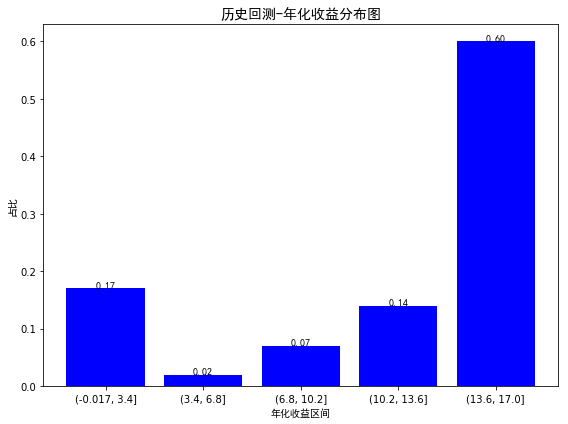

In [26]:
#加空行后再画一个直方图
import pandas as pd
import matplotlib.pyplot as plt
from docx.shared import Inches
from matplotlib.font_manager import FontProperties

doc = Document("看涨价差回测文档.docx")
doc.add_paragraph()
paragraph_text = "收益分布"
paragraph = doc.add_paragraph(paragraph_text)

#将频数图转化后绘制收益分布图
fre=pd.DataFrame(frequency)
fre['频率']=fre['区间']/fre['区间'].sum()
#fre['频率']=fre['频率'].apply(lambda x: f'{x:.2%}')
fre['频率']=fre['频率'].round(2)
fre['区间分布']=0
for i in range(len(fre)):
    fre.iloc[i,2]=str(fre.index[i])
    fre.iloc[i,1]=float(fre.iloc[i,1])

# 绘制年化收益率分布直方图
# 设置中文字体（使用系统自带的SimHei字体）
font = FontProperties(fname='C:/Windows/Fonts/SimHei.ttf')

# 绘制年化收益率分布直方图
plt.figure(figsize=(8, 6))
bars = plt.bar(fre['区间分布'], fre['频率'], color='blue')
plt.xlabel('年化收益区间', fontproperties=font)
plt.ylabel('占比', fontproperties=font)
plt.title('历史回测-年化收益分布图', fontproperties=font, fontsize=14)

# 在直方图上方添加频率值标签（显示两位小数）
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontproperties=font, color='black')

plt.tight_layout()
plt.savefig('figure.png')  # 保存图形为图片文件
plt.show()
paragraph = doc.add_paragraph()
run = paragraph.add_run()
pic = run.add_picture('figure.png', width=Inches(6), height=Inches(3))
paragraph.alignment = 1  # 居中对齐
# 保存修改后的文档
doc.save("看涨价差回测文档.docx")

In [28]:
#更改最终生成的文档字体
from docx import Document
from docx.shared import Pt
from docx.oxml.ns import qn

doc = Document("看涨价差回测文档.docx")
# 设置字体为微软雅黑
font_name = "微软雅黑"

for paragraph in doc.paragraphs:
    for run in paragraph.runs:
        run.font.name = font_name
        # 如果要设置其他样式，如字号，可以进行相应的设置
        # run.font.size = Pt(12)

# 设置所有表格中的字体为微软雅黑
for table in doc.tables:
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.name = font_name

# 保存修改后的文档
doc.save("看涨价差回测文档.docx")

## 绘制突破K线对应图

In [33]:
from WindPy import w  # 第一步：导入 WindPy 模块
w.start() # 第二步：启动 API 接口
k_value=w.wsd("000852.SH", "open,close,low,high", begin_date, interrupt_date, usedf=True)[1]
k_value.columns= ['open','close','low','high']
w.close()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


In [35]:
k_value

,open,close,low,high
2017-01-03,8503.6606,8565.1363,8503.6606,8565.3373
2017-01-04,8567.2280,8669.9492,8554.1270,8670.1575
2017-01-05,8665.2280,8670.7612,8657.7442,8694.4443
2017-01-06,8661.6920,8609.8985,8603.9116,8666.6632
2017-01-09,8595.9105,8653.8468,8578.9874,8654.1324
...,...,...,...,...
2022-07-22,7081.5627,7034.5975,6969.4308,7124.3035
2022-07-25,7037.7554,6948.9088,6933.8186,7068.3408
2022-07-26,6949.1898,7027.4189,6901.9321,7031.1124
2022-07-27,7018.2244,7099.4335,7005.0698,7109.5393


In [39]:
usedata=k_value.values.tolist()
df=pd.read_excel('看涨价差回测表.xlsx')
import requests
from typing import List, Union

from pyecharts import options as opts
from pyecharts.charts import Kline, Line, Bar, Grid


kline_data = usedata
# print(kline_data)
kline = (
    Kline()
    .add_xaxis(xaxis_data=k_value.index.tolist())
    .add_yaxis(
        series_name=trade_code,
        y_axis=kline_data,
        itemstyle_opts=opts.ItemStyleOpts(color="#ec0000", color0="#00da3c"),
    )
    .set_global_opts(
        legend_opts=opts.LegendOpts(
            is_show=False, pos_bottom=10, pos_left="center"
        ),
        datazoom_opts=[
            opts.DataZoomOpts(
                is_show=False,
                type_="inside",
                xaxis_index=[0, 1],
                range_start=98,
                range_end=100,
            ),
            opts.DataZoomOpts(
                is_show=True,
                xaxis_index=[0, 1],
                type_="slider",
                pos_top="85%",
                range_start=98,
                range_end=100,
            ),
        ],
        yaxis_opts=opts.AxisOpts(
            is_scale=True,
            splitarea_opts=opts.SplitAreaOpts(
                is_show=True, areastyle_opts=opts.AreaStyleOpts(opacity=1)
            ),
        ),
        tooltip_opts=opts.TooltipOpts(
            trigger="axis",
            axis_pointer_type="cross",
            background_color="rgba(245, 245, 245, 0.8)",
            border_width=1,
            border_color="#ccc",
            textstyle_opts=opts.TextStyleOpts(color="#000"),
        ),
        visualmap_opts=opts.VisualMapOpts(
            is_show=False,
            dimension=2,
            series_index=5,
            is_piecewise=True,
            pieces=[
                {"value": 1, "color": "#00da3c"},
                {"value": -1, "color": "#ec0000"},
            ],
        ),
        axispointer_opts=opts.AxisPointerOpts(
            is_show=True,
            link=[{"xAxisIndex": "all"}],
            label=opts.LabelOpts(background_color="#777"),
        ),
        brush_opts=opts.BrushOpts(
            x_axis_index="all",
            brush_link="all",
            out_of_brush={"colorAlpha": 0.1},
            brush_type="lineX",
        ),
    )
)

line = (
    Line()
    .add_xaxis(xaxis_data=k_value.index.tolist())
    .add_yaxis(
        series_name="初始突破线",
        y_axis=df['突破价格'].tolist(),
        is_smooth=True,
        is_hover_animation=False,
        linestyle_opts=opts.LineStyleOpts(width=3, opacity=0.5),
        label_opts=opts.LabelOpts(is_show=False),
    )

    .set_global_opts(xaxis_opts=opts.AxisOpts(type_="category"))
)

bar = (
    Bar()
    .add_xaxis(xaxis_data=k_value.index.tolist())
    .add_yaxis(
        series_name="是否突破",
        y_axis=df['是否突破'].tolist(),
        xaxis_index=1,
        yaxis_index=1,
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(
            type_="category",
            is_scale=True,
            grid_index=1,
            boundary_gap=False,
            axisline_opts=opts.AxisLineOpts(is_on_zero=False),
            axistick_opts=opts.AxisTickOpts(is_show=False),
            splitline_opts=opts.SplitLineOpts(is_show=False),
            axislabel_opts=opts.LabelOpts(is_show=False),
            split_number=20,
            min_="dataMin",
            max_="dataMax",
        ),
        yaxis_opts=opts.AxisOpts(
            grid_index=1,
            is_scale=True,
            split_number=2,
            axislabel_opts=opts.LabelOpts(is_show=False),
            axisline_opts=opts.AxisLineOpts(is_show=False),
            axistick_opts=opts.AxisTickOpts(is_show=False),
            splitline_opts=opts.SplitLineOpts(is_show=False),
        ),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)

# Kline And Line
overlap_kline_line = kline.overlap(line)

# Grid Overlap + Bar
grid_chart = Grid(
    init_opts=opts.InitOpts(
        width="1000px",
        height="800px",
        animation_opts=opts.AnimationOpts(animation=False),
    )
)
grid_chart.add(
    overlap_kline_line,
    grid_opts=opts.GridOpts(pos_left="10%", pos_right="8%", height="50%"),
)
grid_chart.add(
    bar,
    grid_opts=opts.GridOpts(
        pos_left="10%", pos_right="8%", pos_top="63%", height="16%"
    ),
)

grid_chart.render_notebook()